This notebook is fully copied and translated to Korean from [@abhinand05's notebook](https://www.kaggle.com/abhinand05/vision-transformer-vit-tutorial-baseline).
If there is an issue, let me know then I will revise it or delete this notebook.

이 노트북은 [@abhinand05's 노트북](https://www.kaggle.com/abhinand05/vision-transformer-vit-tutorial-baseline)에서 전부 복사되고 한글로 번역하였습니다. 만약 문제가 있다면, 해당 부분을 수정하거나 이 노트북을 삭제하겠습니다.

In [1]:
!cp -r ../input/vittutorialillustrations/* ./ 

!pip install nb_black
%load_ext nb_black

  Created wheel for nb-black: filename=nb_black-1.0.7-py3-none-any.whl size=5280 sha256=fac17094fdeb944d221c255750a75be82e38f990398e1331dd0c3def2b44828e
  Stored in directory: /root/.cache/pip/wheels/1e/b2/88/51c66d23ea5fd0d40ed50997555e15d981d92671376a9a412a
Successfully built nb-black
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


<IPython.core.display.Javascript object>

# 서론

이 노트북은 제목과 같이 두 파트로 나뉩니다.

<a href="#Vision-Transformers:-A-gentle-introduction">1. Vision Transformer란?</a> <br>
<a href="#Vision-Transformer-Implementation-in-PyTorch">2. 파이토치 구현</a>

**Pytorch에서 ViT를 구현하기 전에 Vision Transformers의 기본 아이디어와 작동 방식을 간략히 설명하겠습니다.**

따라서 코드에만 관심이 있다면 이 노트북의 두 번째 세션부터 읽으세요. [rwightman/pytorch-image-models](https://github.com/rwightman/pytorch-image-models) 라이브러리가 pretrained weights를 포함한 모델 구현을 모두 포함하고 있기때문에, 구현은 기존 방식과 크게 다르지 않습니다.

# <font size=4 color='blue'>이 노트북이 도움이 된다면, 추천부탁드립니다.</font>

# Vision Transformers란?

Vision Transformers(ViT)는 2020년 10월 구글 브레인팀이 발표한 [AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE 논문](https://arxiv.org/pdf/2010.11929.pdf)에서 소개되었습니다.

ViT가 어떻게 동작하는지 이해하기 위해서 Transformers의 작동방식과 해결가능한 문제에 대해 사전지식이 필요합니다. Vit의 디테일한 설명 이전에 어떻게 transformers가 동작하는지 먼저 설명하겠습니다.

![ViT-Illustration](vision-transformer.png)

만약 NLP가 처음이고 transformer 모델에 대해 배우고 실제로 어떻게 작동하는지 직관적인 설명을 알고 싶다면 이 [블로그 포스트](https://jalammar.github.io/)를 보는 걸 추천드립니다. (위 이미지 또한 이 블로그 포스트 글에서 인용하였습니다.)

## Transformers: 간략한 설명

> **만약 Transformers에 대해 이해하고 있다면, 이 파트를 넘어가셔도 좋습니다.**

Transformer는 자연어 처리문제를 혁신하였습니다. 처음 소개가 되었을 때, 여러 NLP 점수기록을 갱신하고 최고 성적을 달성하였습니다. 이제는 현대 NLP의 실질적인 표준이 되었고 LSTM 및 GRU와 같은 이전 세대 모델에 비해 큰 성능향상을 이루었습니다.

NLP를 바꾼 가장 중요한 논문은 ["Attention is all you need"](https://arxiv.org/pdf/1706.03762.pdf) 입니다. Transformer 구조가 이 논문에서 소개되었기 때문이죠.

## **Motivations:**

squence와 NLP 문제를 위한 이전의 모델들은 발전된 RNN의 형태를 지닙니다. **이 모델들의 문제점은 long-term dependencies를 이해할 수 없습니다.**

RNN의 변형인 LSTM과 GRU은 그러한 depencies를 이해할 순 있지만 제한적입니다.

그러므로 Transformer의 motivation은 이러한 재발을 없애고 거의 모든 dependencies를 포착하는 것이었습니다. 더욱 정확히 말하면, transformer의 시야는 입력 전체입니다. 이러한 *self-attention(multi-headed)* 이라고 불리는 attention mechanism은 성능 향상의 주된 이유였습니다. 다른 이점 중 하나는 데이터를 병렬적으로 처리할 수 있다는 것입니다.


### Transformer 구조
**참고: 이 후 설명에 들어가는 각 단계에 대한 번호가 이 그림에 표시되어 있습니다.**

![TranformerArchitecture](transformer-arch.png)

- 트랜스포머에는 위의 다이어그램에서 왼쪽에 있는 디코더와 오른쪽에 있는 인코더라는 두 가지 부분이 있습니다. 
- 지금 우리가 기계번역을 하고 있다고 상상해보세요.
- 인코더는 입력 데이터(문장)를 가져와서 입력의 중간 표현을 생성합니다. 
- 디코더는 이 중간 표현을 단계별로 디코딩하고 출력을 생성합니다. 그러나 이 둘의 차이점은 작동방식입니다.
- ViT에는 인코더 섹션을 이해하는 것으로 충분합니다.

> **참고: 이 설명은 모델 구조에 대한 직관적인 설명입니다. 좀 더 자세한 내용은 각각의 논문을 확인해주세요.**

### Tranformers: 단계별 설명
**(1)** 입력 데이터는 먼저 벡터에 임베딩됩니다. 임베딩 레이어는 각 단어에 대해 vector representation을 나타내는 데 도움이 됩니다.

**(2)** 다음 단계에서 위치 인코딩이 입력 임베딩에 들어갑니다. 이는 Transformer가 입력으로 전달되는 시퀀스 순서(예: 문장)에 대해 전혀 모르기 때문입니다.

**(3)** 이제 multi-headed attention은 값들이 조금씩 달라지는 부분입니다.

**Multi-headed-attention 구조:**
![multi-headed-attn](multi-headed-attention.png)

**(4)** Multi-Headed Attention 은 세 가지 학습 가능한 벡터로 구성됩니다. Query, Key 및 Value 벡터입니다. 이는 검색(Query)과 검색 엔진이 Query를 Key와 비교하고 Value로 응답하는 정보 검색에서 비롯된다고 합니다.

**(5)** Q와 K 표현은 한 단어가 다른 모든 단어에 얼마나 많이 참여해야 하는지를 나타내는 점수 행렬을 생성하기 위해 내적을 합니다. 점수가 높으면 더 많은 관심을 받고 그 반대도 됩니다.

**(6)** 그런 다음 Q 및 K 벡터의 차수에 따라 점수 행렬이 축소됩니다. 이는 곱셈이 폭발적 효과를 가질 수 있기 때문에 보다 안정적인 gradients를 보장하기 위한 것입니다.

(디코더를 설명할 때, Mask 부분에 대해 설명하겠습니다.)

**(7)** 다음으로 점수 행렬이 Softmax되어 Attention 점수를 확률로 변환합니다. 더 높은 점수는 단어의 관심이 상승되고 낮은 점수는 하락합니다. 이렇게 하면 모델이 어떤 단어를 많이, 혹은 적게 사용할지 결정할 수 있습니다.

**(8)** 그런 다음 확률이 있는 결과 행렬에 Value 벡터를 곱합니다. 이렇게 하면 Model이 학습한 확률 점수가 더 중요해집니다. 점수가 낮은 단어들은 효과적으로 빠져 나와 영향력이 낮아질 것입니다.

**(9)** 그런 다음 QK 및 V 벡터의 연결된 출력을 선형 레이어에 공급하여 더 자세히 처리합니다.

**(10)** Self-Attention이 시퀀스의 각 단어에 대해 이루어집니다. Self-Attention은 다른 Self-Attention에 의존하지 않기 때문에 Self-Attention 모듈의 복사본을 사용하여 모든 것을 동시에 처리할 수 있습니다. **(multi-headed)**.

**(11)** 그런 다음 출력 값 벡터가 연결되고 입력 계층에서 유입되는 residual connection에 추가되며 그 결과 representation은 정규화를 위해 *LayerNorm*로 전달됩니다. (residual connection은 gradient가 네트워크를 통해 흐를 수 있도록 도와주며 LayernNorm은 교육 시간을 약간 줄이고 네트워크를 안정시키는 데 도움이 됩니다.)

**(12)** 또한 출력 값을 포인트별 feed forward 네트워크로 전달하여 더 풍부한 representation을 얻습니다.

**(13)** 출력이 다시 LayerNorm을 통과하고 이전 레이어에서 residual이 추가됩니다.


**참고: 인코더 섹션을 마치면 Vision Transformer를 완전히 이해할 수 있습니다. 인코딩 계층과 매우 유사하기 때문에 디코더 부분을 이해하도록 하겠습니다.**

**(14)** 디코더 부분에서는 인코더 결과값이 masked-multi headed attention를 거쳐 그 다음 attention layer로 들어갑니다. 이전 time step 혹은 단어의 입력의 인코더의 결과가 있는 경우에는 같이 들어갑니다.

**(15)** 모델이 디코딩 중에 나중에 나올 단어를 확인할 수 없으므로 누출이 발생하지 않도록 Masked multi headed attention가 필요합니다. 이 작업은 점수 행렬의 나중에 나오는 단어 항목을 마스킹하여 수행됩니다. 현재 단어와 이전 단어들을 1로 추가하고 미래 단어 점수를 -inf로 추가합니다. 이렇게 하면 Softmax로 확률을 얻으면 나머지는 그대로 유지할 때 미래 단어는 0으로 감소됩니다.

**(16)** Gradient의 흐름을 개선하기 위한 Residual Connection도 있습니다. 마지막으로 출력이 선형 레이어로 전송되고 Softmax되어 확률로 출력을 얻습니다.

## Vision Transformers는 어떻게 작동하나요?

이제 우리는 Transformers의 구조를 자세히 다루었으므로, Vision Transformers에 대한 문제를 해결할 준비가 되었습니다.

이미지에 트랜스포머를 적용하는 것은 아래와 같은 이유로 어려운 문제였습니다.
- 단어/문장/문단과는 달리, 이미지는 기본적으로 픽셀 형태로 훨씬 더 많은 정보를 포함합니다.
- 고사양 하드웨어가 있더라도 이미지의 다른 모든 픽셀을 인식하기는 매우 어려울 것입니다.
- 이에 대한 대안은 localized attention을 사용하는 것이었습니다. 
- 사실 CNN은 컨볼루션을 통해 매우 유사한 기능을 하고 인지 범위는 모델의 레이어에 깊이 들어갈수록 더 커지지만 Transformer는 'Transformer'의 특성상 CNN보다 항상 계산적으로 더 비쌀 것입니다. 물론, 우리는 CNN이 현재의 컴퓨터 비전 발전에 얼마나 많은 기여를 했는지 알고 있습니다.

구글 연구원들은 그들의 논문에서 컴퓨터 비전의 다음 큰 단계가 될 수 있는 것으로 다른 구조를 제안했습니다. 그들은 CNN에 대한 의존이 더 이상 필요하지 않을 수도 있다는 것을 보여줍니다. 이제 Vision Transformers에 대해 자세히 살펴보겠습니다.

### Vision Transformer 구조

![vit-architecture](vit-arch.png)

**(1)** 이들은 Transformer의 인코더 부분만 사용하지만, 다른 점은 이미지를 네트워크에 입력하는 방식에 있습니다.

**(2)** 이미지를 고정 크기의 패치들로 나누었습니다. 따라서 이러한 패치 중 하나는 16x16 또는 32x32가 될 수 있습니다. 패치가 많을수록 패치 자체의 크기가 작아질수록 이러한 모델을 더 쉽게 교육할 수 있습니다. 그래서 "An Image is worth 16x16 words"라는 제목은 이러한 점을 나타냅니다.

**(3)** 패치는 flattened되고 추가 처리를 위해 모델로 입력됩니다.

**(4)** 여기에서는 NN과 달리 모델이 시퀀스의 샘플 위치에 대해 전혀 알지 못합니다. 여기서 각 샘플은 입력 이미지의 패치입니다. 따라서 이미지는 **positional embedding vector** 와 함께 인코더로 공급됩니다. 여기서 주목해야 할 한 가지는 위치 임베딩도 학습할 수 있다는 것입니다. 따라서 하드 코딩된 벡터를 해당 위치에 실제로 공급하지 않습니다.

**(5)** 시작 부분에는 BERT와 같은 특수 토큰도 있습니다.

**(6)** 따라서 각 이미지 패치는 먼저 큰 벡터로 flattened되고 학습 가능한 embedding matrix와 함께 곱해져 embedded patch를 생성합니다. 그리고 이 embedded patch는 positional embedding vector와 결합되어 Transformer에 공급됩니다.

> **참고: 여기서부터는 모든 것이 기존 Transformer와 동일합니다**

**(7)** 유일한 차이점은 디코더 대신 인코더의 출력을 feed-forward 신경망으로 직접 전달하여 분류 출력을 얻는 것입니다.

### 유의할 사항:
- 본 논문은 컨볼루션에 대해 거의 완전히 무시합니다. 
- 그러나 이미지 패치의 컨볼루션 embedding이 사용되는 ViT의 두 가지 변형을 사용하고 있습니다. 하지만 성능에 큰 영향을 미치지 않는 것 같습니다.  
- 이 문서를 작성할 당시 Vision Transformers는 ImageNet의 이미지 분류 벤치마크에서 1위를 차지했습니다.

<img src="benchmarks-chart.png" width="700">
<!-- ![BenchmarksChart](benchmarks-charpng) -->

- 본 논문에서는 훨씬 더 흥미로운 점이 많지만, CNN을 통해 Transformer의 힘을 보여 줄 수 있는 한 가지는 아래 이미지에 나와 있습니다. 아래 이미지는 레이어에 대한 attention distance를 보여줍니다.

<img src="attn-distance.png" width="300" height="300">
<br>

- 위의 그래프는 Transformer가 시작부터 멀리 떨어져 있는 영역에 대해 이미 Attention을 나타낼 수 있음을 시사하며, 이는 처음에 제한된 수신 필드를 가진 CNN에 비해 Transformer가 가진 상당한 장점입니다.

# <font size=4 color='blue'>이 노트북이 도움이 된다면, 추천부탁드립니다.</font>

## Vision Transformer 파이토치 구현
이제 Vision Transformer에 대해 이해하였으니 이제 [이 대회](https://www.kaggle.com/c/cassava-leaf-disease-classification)를 위한 베이스라인을 구축해 보겠습니다.

먼저 torch-images-models(timm)과 TPU를 사용하기 위해 torch-xla를 설치하겠습니다.

In [2]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version 1.7
!pip install timm

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  36542      0 --:--:-- --:--:-- --:--:-- 36805
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-1.7 ...
Found existing installation: torch 1.5.0
Uninstalling torch-1.5.0:
  Successfully uninstalled torch-1.5.0
Found existing installation: torchvision 0.6.0a0+35d732a
Uninstalling torchvision-0.6.0a0+35d732a:
Done updating TPU runtime
  Successfully uninstalled torchvision-0.6.0a0+35d732a
Copying gs://tpu-pytorch/wheels/torch-1.7-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/114.2 MiB.                                    
Copying gs://tpu-pytorch/wheels/torch_xla-1.7-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/127.4 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-1.7-cp37-cp37m-linux_x86_64.whl..

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl

import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics

<IPython.core.display.Javascript object>

In [4]:
# TPU 병렬화를 위한 설정
os.environ["XLA_USE_BF16"] = "1"
os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"

<IPython.core.display.Javascript object>

In [5]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

<IPython.core.display.Javascript object>

In [6]:
# 일반적인 전역 변수들
DATA_PATH = "../input/cassava-leaf-disease-classification"
TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images/"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images/"
MODEL_PATH = (
    "../input/vit-base-models-pretrained-pytorch/jx_vit_base_p16_224-80ecf9dd.pth"
)

# 모델 전역 변수
IMG_SIZE = 224
BATCH_SIZE = 16
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 10

<IPython.core.display.Javascript object>

In [7]:
df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


<IPython.core.display.Javascript object>

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


<IPython.core.display.Javascript object>

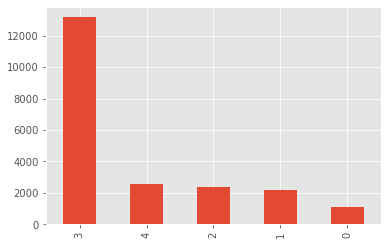

<IPython.core.display.Javascript object>

In [9]:
df.label.value_counts().plot(kind="bar")

In [10]:
train_df, valid_df = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.label.values
)

<IPython.core.display.Javascript object>

In [11]:
class CassavaDataset(torch.utils.data.Dataset):
    """
    Dataset을 구축하기 위한 기본 코드
    """

    def __init__(self, df, data_path=DATA_PATH, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "train_images" if mode == "train" else "test_images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(img)

        return image, label

<IPython.core.display.Javascript object>

In [12]:
# image augmentation 생성
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

<IPython.core.display.Javascript object>

In [13]:
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

Available Vision Transformer Models: 


['vit_base_patch16_224',
 'vit_base_patch16_384',
 'vit_base_patch32_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50d_224',
 'vit_huge_patch16_224',
 'vit_huge_patch32_384',
 'vit_large_patch16_224',
 'vit_large_patch16_384',
 'vit_large_patch32_384',
 'vit_small_patch16_224',
 'vit_small_resnet26d_224',
 'vit_small_resnet50d_s3_224']

<IPython.core.display.Javascript object>

In [14]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
        if pretrained:
            self.model.load_state_dict(torch.load(MODEL_PATH))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # training loss를 추적하기 위한 변수
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        #     모델 학습    #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # CUDA가 있다면 gpu로 데이터를 이동
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # 모든 optimized variable에 대해 gradient 초기화
            optimizer.zero_grad()
            # forward pass: 모델에 input을 입력함으로써 예측값 계산
            output = self.forward(data)
            # batch loss 계산
            loss = criterion(output, target)
            # backward pass: 모델 파라미터에 대한 loss의 gradient 계산
            loss.backward()
            # 정확도 계산
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # training loss 및 정확도 업데이트
            epoch_loss += loss
            epoch_accuracy += accuracy

            # 최적화 단계 (파라미터 업데이트)
            if device.type == "xla":
                xm.optimizer_step(optimizer)

                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # validation loss를 추적하기 위한 변수
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        #      모델 평가      #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            # CUDA가 있다면 gpu로 데이터를 이동
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            with torch.no_grad():
                # forward pass: 모델에 input을 입력함으로써 예측값 계산
                output = self.model(data)
                # batch loss 계산
                loss = criterion(output, target)
                # 정확도 계산
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # validation loss와 정확도 업데이트
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

<IPython.core.display.Javascript object>

In [15]:
def fit_tpu(
    model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
):

    valid_loss_min = np.Inf  # validation loss의 변화 추적을 위한 변수

    # loss 추적을 위한 변수들
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        para_train_loader = pl.ParallelLoader(train_loader, [device])

        xm.master_print(f"{'='*50}")
        xm.master_print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(
            para_train_loader.per_device_loader(device), criterion, optimizer, device
        )
        xm.master_print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        if valid_loader is not None:
            gc.collect()
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            xm.master_print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(
                para_valid_loader.per_device_loader(device), criterion, device
            )
            xm.master_print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            # validation loss가 줄어들면 모델 저장
            if valid_loss <= valid_loss_min and epoch != 1:
                xm.master_print(
                    "Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...".format(
                        valid_loss_min, valid_loss
                    )
                )
            #                 xm.save(model.state_dict(), 'best_model.pth')

            valid_loss_min = valid_loss

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

<IPython.core.display.Javascript object>

In [16]:
model = ViTBase16(n_classes=5, pretrained=True)

<IPython.core.display.Javascript object>

In [17]:
def _run():
    train_dataset = CassavaDataset(train_df, transforms=transforms_train)
    valid_dataset = CassavaDataset(valid_df, transforms=transforms_valid)

    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True,
    )

    valid_sampler = torch.utils.data.distributed.DistributedSampler(
        valid_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False,
    )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        drop_last=True,
        num_workers=8,
    )

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_sampler,
        drop_last=True,
        num_workers=8,
    )

    criterion = nn.CrossEntropyLoss()
    #     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = xm.xla_device()
    model.to(device)

    lr = LR * xm.xrt_world_size()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xm.master_print(f"INITIALIZING TRAINING ON {xm.xrt_world_size()} TPU CORES")
    start_time = datetime.now()
    xm.master_print(f"Start Time: {start_time}")

    logs = fit_tpu(
        model=model,
        epochs=N_EPOCHS,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )

    xm.master_print(f"Execution time: {datetime.now() - start_time}")

    xm.master_print("Saving Model")
    xm.save(
        model.state_dict(), f'model_5e_{datetime.now().strftime("%Y%m%d-%H%M")}.pth'
    )

<IPython.core.display.Javascript object>

In [18]:
# 학습 시작
def _mp_fn(rank, flags):
    torch.set_default_tensor_type("torch.FloatTensor")
    a = _run()


# _run()
FLAGS = {}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method="fork")

INITIALIZING TRAINING ON 8 TPU CORES
Start Time: 2021-01-22 14:46:48.232790
EPOCH 1 - TRAINING...
	BATCH 1/150 - LOSS: 1.609375
	BATCH 21/150 - LOSS: 0.7734375
	BATCH 41/150 - LOSS: 0.33984375
	BATCH 61/150 - LOSS: 0.333984375
	BATCH 81/150 - LOSS: 0.314453125
	BATCH 101/150 - LOSS: 0.765625
	BATCH 121/150 - LOSS: 0.439453125
	BATCH 141/150 - LOSS: 0.451171875

	[TRAIN] EPOCH 1 - LOSS: 0.59765625, ACCURACY: 0.83203125

EPOCH 1 - VALIDATING...
	[VALID] LOSS: 0.419921875, ACCURACY: 0.84375

EPOCH 2 - TRAINING...
	BATCH 1/150 - LOSS: 0.458984375
	BATCH 21/150 - LOSS: 0.2734375
	BATCH 41/150 - LOSS: 0.1396484375
	BATCH 61/150 - LOSS: 0.177734375
	BATCH 81/150 - LOSS: 0.14453125
	BATCH 101/150 - LOSS: 0.5703125
	BATCH 121/150 - LOSS: 0.32421875
	BATCH 141/150 - LOSS: 0.60546875

	[TRAIN] EPOCH 2 - LOSS: 0.41796875, ACCURACY: 0.9140625

EPOCH 2 - VALIDATING...
	[VALID] LOSS: 0.4140625, ACCURACY: 0.83984375

Validation loss decreased (0.4199 --> 0.4141).  Saving model ...
EPOCH 3 - TRAINING..

<IPython.core.display.Javascript object>

## 읽어주셔서 감사합니다.

# <font size=4 color='blue'>이 노트북이 도움이 된다면, 추천 부탁드립니다.</font>